Analyze 8/19-27 -- neq switching without rest, with flattening

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    

## T42A, A42T

In [8]:
# Load data into dicts and plot 
titles = ["T42A", "A42T"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 8
forward = 19
reverse = 20
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                d_combined_works[phase][direction] = combined
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 19
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/19/19_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/19/19_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/19/19_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/19/19_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [9]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

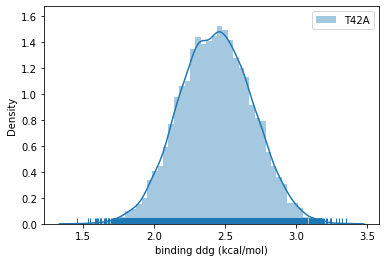

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=titles[1])
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [14]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]

In [15]:
output_kcalmol

[2.43, (1.94, 2.93)]

In [16]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [17]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

## Y29A, A29Y

In [25]:
# Load data into dicts and plot 
titles = ["Y29A", "A29Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 8
forward = 21
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                d_combined_works[phase][direction] = combined
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-first])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-first])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 21
100
100
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/21/21_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/8/21/21_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [26]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

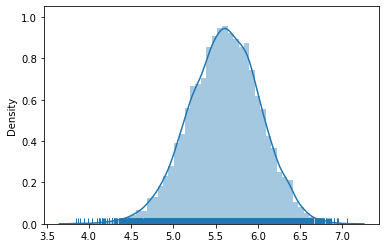

In [27]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [28]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]

In [29]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [30]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

## W38F, F38W

In [31]:
# Load data into dicts and plot 
titles = ["W38F", "F38W"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 8
forward = 23
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                d_combined_works[phase][direction] = combined
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 23
job: 0
(1, 20001)
job: 1
(1, 20001)
job: 2
(1, 20001)
job: 3
(1, 20001)
job: 4
(1, 20001)
job: 5
(1, 20001)
job: 6
(1, 20001)
job: 7
(1, 20001)
job: 8
(1, 20001)
job: 9
(1, 20001)
job: 10
(1, 20001)
job: 11
(1, 20001)
job: 12
(1, 20001)
job: 13
(1, 20001)
job: 14
(1, 20001)
job: 15
(1, 20001)
job: 16
(1, 20001)
job: 17
(1, 20001)
job: 18
(1, 20001)
job: 19
(1, 20001)
job: 20
(1, 20001)
job: 21
(1, 20001)
job: 22
(1, 20001)
job: 23
(1, 20001)
job: 24
(1, 20001)
job: 25
(1, 20001)
job: 26
(1, 20001)
job: 27
(1, 20001)
job: 28
(1, 20001)
job: 29
(1, 20001)
job: 30
(1, 20001)
job: 31
(1, 20001)
job: 32
(1, 20001)
job: 33
(1, 20001)
job: 34
(1, 20001)
job: 35
(1, 20001)
job: 36
(1, 20001)
job: 37
(1, 20001)
job: 38
(1, 20001)
job: 39
(1, 20001)
job: 40
(1, 20001)
job: 41
(1, 20001)
job: 42
(1, 20001)
job: 43
(1, 20001)
job: 44
(1, 20001)
job: 45
(1, 20001)
job: 46
(1, 20001)
job: 47
(1, 20001)
job: 48
(1, 20001)
job: 49
(1, 20001)
job: 50
(1, 20001)
job: 51
(1, 20001)
job: 52
(1, 20

<Figure size 432x288 with 0 Axes>

In [32]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

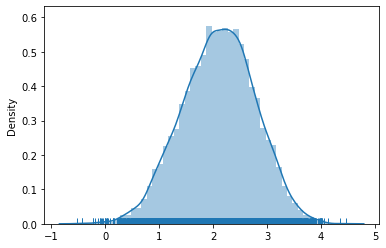

In [34]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [35]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]

In [36]:
output_kcalmol

[1.25, (0.46, 2.01)]

In [37]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [38]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

## W44F, F44W

In [39]:
# Load data into dicts and plot 
titles = ["W44F", "F44W"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 8
forward = 25
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                d_combined_works[phase][direction] = combined
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 25
job: 0
(1, 20001)
job: 1
(1, 20001)
job: 2
(1, 20001)
job: 3
(1, 20001)
job: 4
(1, 20001)
job: 5
(1, 20001)
job: 6
(1, 20001)
job: 7
(1, 20001)
job: 8
(1, 20001)
job: 9
(1, 20001)
job: 10
(1, 20001)
job: 11
(1, 20001)
job: 12
(1, 20001)
job: 13
(1, 20001)
job: 14
(1, 20001)
job: 15
(1, 20001)
job: 16
(1, 20001)
job: 17
(1, 20001)
job: 18
(1, 20001)
job: 19
(1, 20001)
job: 20
(1, 20001)
job: 21
(1, 20001)
job: 22
(1, 20001)
job: 23
(1, 20001)
job: 24
(1, 20001)
job: 25
(1, 20001)
job: 26
(1, 20001)
job: 27
(1, 20001)
job: 28
(1, 20001)
job: 29
(1, 20001)
job: 30
(1, 20001)
job: 31
(1, 20001)
job: 32
(1, 20001)
job: 33
(1, 20001)
job: 34
(1, 20001)
job: 35
(1, 20001)
job: 36
(1, 20001)
job: 37
(1, 20001)
job: 38
(1, 20001)
job: 39
(1, 20001)
job: 40
(1, 20001)
job: 41
(1, 20001)
job: 42
(1, 20001)
job: 43
(1, 20001)
job: 44
(1, 20001)
job: 45
(1, 20001)
job: 46
(1, 20001)
job: 47
(1, 20001)
job: 48
(1, 20001)
job: 49
(1, 20001)
job: 50
(1, 20001)
job: 51
(1, 20001)
job: 52
(1, 20

<Figure size 432x288 with 0 Axes>

In [40]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

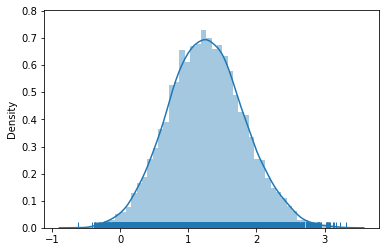

In [41]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [42]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]

In [43]:
output_kcalmol

[0.75, (0.12, 1.43)]

In [44]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [45]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

## Y29F, F29Y

In [46]:
# Load data into dicts and plot 
titles = ["Y29F", "F29Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 8
forward = 27
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                d_combined_works[phase][direction] = combined
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 27
job: 0
(1, 20001)
job: 1
(1, 20001)
job: 2
(1, 20001)
job: 3
(1, 20001)
job: 4
(1, 20001)
job: 5
(1, 20001)
job: 6
(1, 20001)
job: 7
(1, 20001)
job: 8
(1, 20001)
job: 9
(1, 20001)
job: 10
(1, 20001)
job: 11
(1, 20001)
job: 12
(1, 20001)
job: 13
(1, 20001)
job: 14
(1, 20001)
job: 15
(1, 20001)
job: 16
(1, 20001)
job: 17
(1, 20001)
job: 18
(1, 20001)
job: 19
(1, 20001)
job: 20
(1, 20001)
job: 21
(1, 20001)
job: 22
(1, 20001)
job: 23
(1, 20001)
job: 24
(1, 20001)
job: 25
(1, 20001)
job: 26
(1, 20001)
job: 27
(1, 20001)
job: 28
(1, 20001)
job: 29
(1, 20001)
job: 30
(1, 20001)
job: 31
(1, 20001)
job: 32
(1, 20001)
job: 33
(1, 20001)
job: 34
(1, 20001)
job: 35
(1, 20001)
job: 36
(1, 20001)
job: 37
(1, 20001)
job: 38
(1, 20001)
job: 39
(1, 20001)
job: 40
(1, 20001)
job: 41
(1, 20001)
job: 42
(1, 20001)
job: 43
(1, 20001)
job: 44
(1, 20001)
job: 45
(1, 20001)
job: 46
(1, 20001)
job: 47
(1, 20001)
job: 48
(1, 20001)
job: 49
(1, 20001)
job: 50
(1, 20001)
job: 51
(1, 20001)
job: 52
(1, 20

<Figure size 432x288 with 0 Axes>

In [47]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

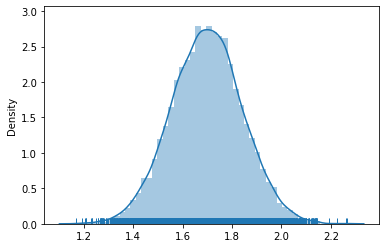

In [48]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [49]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]

In [50]:
output_kcalmol

[1.01, (0.84, 1.18)]

In [51]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [52]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/output_{titles[0]}_{titles[1]}.pickle", "wb") as f:
    pickle.dump(output_kcalmol, f)

In [53]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

## Plot all ddgs

In [75]:
# title_pairs = [["T42A", "A42T"], ["Y29A", "A29Y"], ["W38F", "F38W"], ["W44F", "F44W"], ["Y29F", "F29Y"]]
title_pairs = [["T42A", "A42T"], ["Y29A", "A29Y"], ["W44F", "F44W"], ["Y29F", "F29Y"]]
dir_num = 13
# subdirs = [6, 40, 42, 44, 46]
subdirs = [6, 40, 44, 46]
to_plot = np.zeros(shape=(len(np.array(title_pairs).flatten()), 3))
for i, subdir in enumerate(subdirs):
    with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{subdir}/ddgs.pickle", "rb") as f:
        ddgs = pickle.load(f)
        to_plot[i*2] = np.array([np.mean(ddgs[subdir])*KT_KCALMOL, np.mean(ddgs[subdir])*KT_KCALMOL - np.percentile(ddgs[subdir], 2.5)*KT_KCALMOL , np.percentile(ddgs[subdir], 97.5)*KT_KCALMOL - np.mean(ddgs[subdir])*KT_KCALMOL])
        to_plot[(i*2)+1] = np.array([np.mean(ddgs[subdir+1])*-KT_KCALMOL, np.mean(ddgs[subdir+1])*KT_KCALMOL*-1 - np.percentile(ddgs[subdir+1], 2.5)*-KT_KCALMOL, np.percentile(ddgs[subdir+1], 97.5)*-KT_KCALMOL - np.mean(ddgs[subdir+1])*KT_KCALMOL*-1]) # take the negative of these so they match the forward transform values

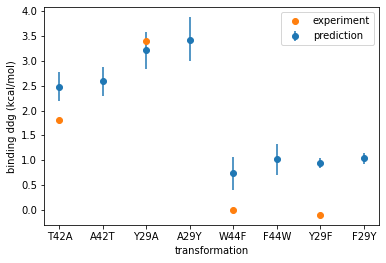

In [92]:
plt.errorbar(list(range(to_plot.shape[0])), to_plot[:,0], yerr=np.transpose(to_plot[:,1:]), ls='none', marker='o', label='prediction')
# exp = [1.8, 3.4, 1.6, 0.0, -0.1]
exp = [1.8, 3.4, 0.0, -0.1]
plt.plot(list(range(0, to_plot.shape[0], 2)), exp, ls='none', marker='o', label='experiment')
plt.ylabel("binding ddg (kcal/mol)")
plt.xlabel("transformation")
plt.xticks(range(to_plot.shape[0]), np.array(title_pairs).flatten())
plt.legend()
plt.savefig(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/ddg_vs_transform_with_cis.png", dpi=400)

## Compute phase discrepancies

In [29]:
dir_num = 8
forward = 31
reverse = 32
titles= ["T42A", "A42T"]
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)

In [32]:
phases = ['apo', 'complex']
outputs_all = []
for phase in phases:
    forward_dgs = [d[phase][0] for d in dgs_phase[forward]]
    forward_dg = np.mean(forward_dgs)
    forward_ci = np.percentile(forward_dgs, 2.5), np.percentile(forward_dgs, 97.5)
    reverse_dgs = [d[phase][0] for d in dgs_phase[reverse]]
    reverse_dg = np.mean(reverse_dgs)
    reverse_ci = np.percentile(reverse_dgs, 2.5), np.percentile(reverse_dgs, 97.5)
    negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
    discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
    output_kt = [forward_dg, forward_ci, reverse_dg, reverse_ci, discrepancy]
    output_kcalmol = [round(forward_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_dg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]
    outputs_all.append(output_kcalmol)
    
    # Plot ddgs
    sns.distplot(np.array(forward_dgs)*KT_KCALMOL, rug=True, label=f"{titles[0]} {phase}")
    sns.distplot(np.array(reverse_dgs)*-KT_KCALMOL, rug=True, label=f"-({titles[1]} {phase})")
    plt.legend()
    plt.xlabel("dg (kcal/mol)")
    plt.savefig(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}_{phase}.png", dpi=400)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [14]:
pd.DataFrame(outputs_all).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}_phases.csv")

## Pull snapshots from annealing T42A

In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller
import seaborn as sns


In [8]:
# Get dihedrals
def get_dihedrals(i, phase, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
    modeller.deleteWater()
    old_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_forward = []
    all_pos_reverse = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_old.npy"), "rb") as f:
                all_pos_forward.append(np.load(f)[0])
        except FileNotFoundError:
            pass
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_reverse_neq_old.npy"), "rb") as f:
                all_pos_reverse.append(np.load(f)[-1])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_forward)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_forward), old_top)
    dihedrals_forward = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
    traj = md.Trajectory(np.array(all_pos_reverse), old_top)
    dihedrals_reverse = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
    
    return dihedrals_forward, dihedrals_reverse

#### Get dihedrals for apo

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/31/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [4]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [9]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_forward_apo, dihedrals_reverse_apo = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:02<00:00, 37.62it/s]

new files found: 100


#### Get dihedrals for complex

In [10]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/31/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [11]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [12]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_forward_complex, dihedrals_reverse_complex = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]

new files found: 83


In [13]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [14]:
# Create list of states for each work traj
states_forward_apo = [get_state(angle) for angle in dihedrals_forward_apo]
states_reverse_apo = [get_state(angle) for angle in dihedrals_reverse_apo]

states_forward_complex = [get_state(angle) for angle in dihedrals_forward_complex]
states_reverse_complex = [get_state(angle) for angle in dihedrals_reverse_complex]

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for his

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

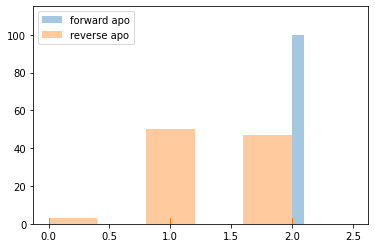

In [15]:
sns.distplot(states_forward_apo, label="forward apo", rug=True, kde=False)
sns.distplot(states_reverse_apo, label="reverse apo", rug=True, kde=False)
# sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
# sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for his

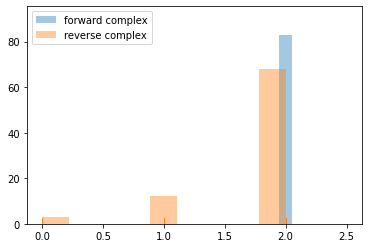

In [16]:
sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

## Pull snapshots from annealing A42T

In [17]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller
import seaborn as sns


In [18]:
# Get dihedrals
def get_dihedrals(i, phase, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
    modeller.deleteWater()
    new_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_forward = []
    all_pos_reverse = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_new.npy"), "rb") as f:
                all_pos_forward.append(np.load(f)[-1])
        except FileNotFoundError:
            pass
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_reverse_neq_new.npy"), "rb") as f:
                all_pos_reverse.append(np.load(f)[0])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_forward)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_forward), new_top)
    dihedrals_forward = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    traj = md.Trajectory(np.array(all_pos_reverse), new_top)
    dihedrals_reverse = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    
    return dihedrals_forward, dihedrals_reverse

#### Get dihedrals for apo

In [19]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [20]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [21]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_forward_apo, dihedrals_reverse_apo = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


new files found: 100


#### Get dihedrals for complex

In [22]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/8/32/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [23]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [24]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_forward_complex, dihedrals_reverse_complex = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]

new files found: 86


In [25]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [26]:
# Create list of states for each work traj
states_forward_apo = [get_state(angle) for angle in dihedrals_forward_apo]
states_reverse_apo = [get_state(angle) for angle in dihedrals_reverse_apo]

states_forward_complex = [get_state(angle) for angle in dihedrals_forward_complex]
states_reverse_complex = [get_state(angle) for angle in dihedrals_reverse_complex]

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for his

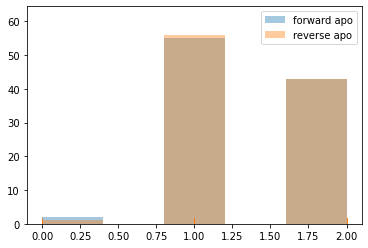

In [27]:
sns.distplot(states_forward_apo, label="forward apo", rug=True, kde=False)
sns.distplot(states_reverse_apo, label="reverse apo", rug=True, kde=False)
# sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
# sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for his

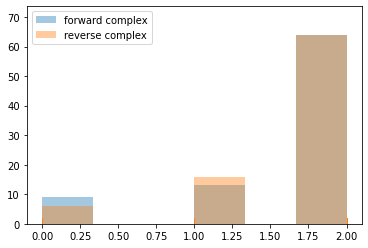

In [28]:
sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()